In [1]:
# !pip install git+https://github.com/facebookresearch/sam2.git


In [2]:
# !pip install opencv-python pycocotools matplotlib onnxruntime onnx

## setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from PIL import Image
from pdf2image import convert_from_path
import os
from tqdm import tqdm
import re
import numpy as np
import  cv2
import matplotlib.pyplot as plt
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [4]:
def pdf_to_images(path, dpi=300):
    images = []
    if os.path.isfile(path):
        images.extend(convert_from_path(path, dpi=dpi))
    else:
        for pdf_file in tqdm(os.listdir(path), desc="Converting PDFs"):
            if pdf_file.lower().endswith('.pdf'):
                pdf_path = os.path.join(path, pdf_file)
                images.extend(convert_from_path(pdf_path, dpi=dpi))
    print(f"\n✅ Conversion complete!")
    return images

pages = pdf_to_images("/Users/maryamsaad/Documents/arabic-ocr-transformer/من معتمدات الكتب/لسان العرب 15 مجلد/لسان العرب (13).pdf")


✅ Conversion complete!


In [5]:
def prepare_image(pages) -> np.ndarray:
    for i, page in enumerate(pages):
        pages[i] = cv2.cvtColor(np.array(page), cv2.COLOR_BGR2RGB)
    return pages
pages=pages[:20]
prepared_pages = prepare_image(pages)
print(len(prepared_pages))


20


## Segment

In [6]:
# !pip install torchvision

In [7]:
# !pip install sam2

In [8]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "/Users/maryamsaad/Documents/arabic-ocr-transformer/sam2.1_hiera_base_plus.pt"
# model_cfg = "/Users/maryamsaad/Documents/arabic-ocr-transformer/sam2.1_hiera_b+.yaml"
# predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))



from hydra import initialize_config_dir
from hydra.core.global_hydra import GlobalHydra
import os

model_cfg_path = "/Users/maryamsaad/Documents/arabic-ocr-transformer/sam2.1_hiera_b+.yaml"
cfg_dir = os.path.dirname(model_cfg_path)
cfg_name = os.path.basename(model_cfg_path)

# clear previous Hydra state if present
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
device="mps" if torch.backends.mps.is_available() else "cpu"
with initialize_config_dir(config_dir=cfg_dir):
    predictor = SAM2ImagePredictor(build_sam2(cfg_name, checkpoint))


ModuleNotFoundError: No module named 'sam2'

In [ ]:
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(<your_image>)
    masks, _, _ = predictor.predict(<input_prompts>)

In [18]:
def show_masks_on_image(image, masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for m in masks:
        seg = m['segmentation']
        color = np.random.rand(3)
        ax.imshow(np.dstack((seg, seg, seg)) * color + (1 - np.dstack((seg, seg, seg))), alpha=0.5)
    plt.axis("off")
    plt.show()


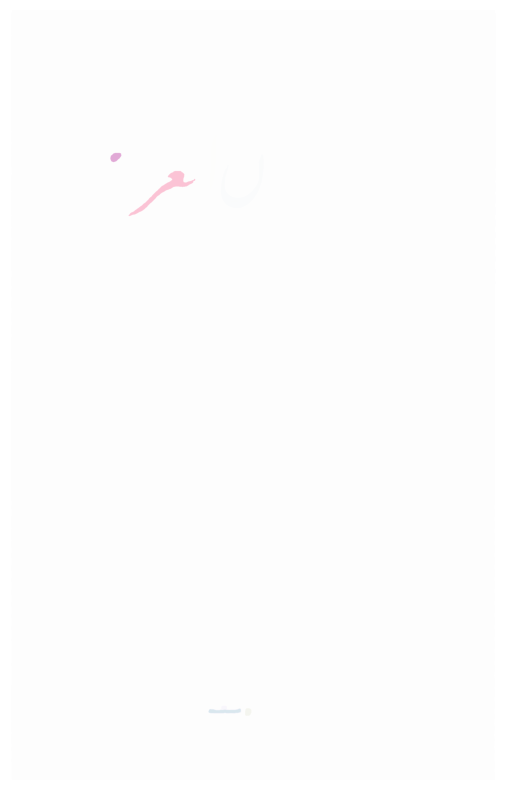

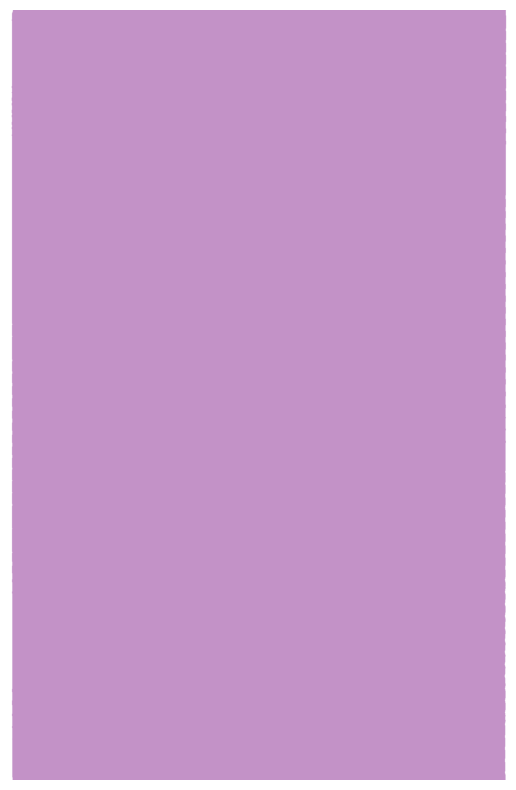

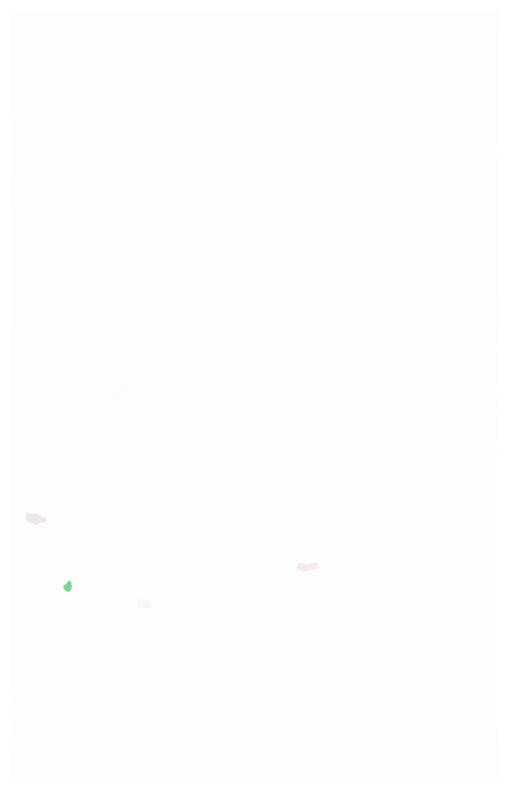

In [ ]:
for page in prepared_pages:
    masks = mask_generator.generate(page)
    show_masks_on_image(page, masks)    
